Loads experimental values for codon & tRNA abundances at different growth rates

In [27]:
import pandas as pd
import pandas as pd
import numpy as np
import sys
import math
import pickle as pkl
import glob
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

%matplotlib inline

## See Maheshwari et al. (2022) mBio, Table S6 

ptRNA = pd.read_excel('../Data/FIG6_S13_S14__ElongationLatencies/tRNAValues.xlsx',header=None)
gr04_ptRNA=ptRNA[0]
gr07_ptRNA=ptRNA[1]
gr107_ptRNA=ptRNA[2]
gr16_ptRNA=ptRNA[3]
gr25_ptRNA=ptRNA[4]

pCodon = pd.read_excel('../Data/FIG6_S13_S14__ElongationLatencies/codonValues.xlsx',header=None)
gr04_pCodon = pCodon[0]
gr07_pCodon = pCodon[1]
gr107_pCodon = pCodon[2]
gr16_pCodon = pCodon[3]
gr25_pCodon = pCodon[4]


/Users/jenniferhofmann/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [16]:
# Adapted from Maheshwari et al. (2022) mBio

def cognateDistrib(ptRNA,pCodon):
    """
    Calculates the probability distribution of the number of cognate ternary complexes (TCs) in a 42-TC translation voxel; see Fig S4 in Maheshwari et al (2022) mBio
        Parameters:
            ptRNA: Pandas series of probability distribution for each tRNA (rows) at growth rate of interest, read from experimental data (above)
            pCodon: Pandas series of probability distribution for each codon (rows) at growth rate of interest, read from experimental data (above)
        Returns:
            p_codon_count_hist_weighted_avg (real): probability distribution of the number of cognate TCs per voxel
    """
    
    ptRNA = np.divide(ptRNA,sum(ptRNA))
    pCodon= np.divide(pCodon, sum(pCodon))

    tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
    "Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
    "Met_m", "Phe", "Pro1", "Pro2", "Pro3", "Sel_Cys", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
    "Thr2", "Thr3", "Thr4", "Trp", "Tyr1pTyr2", "Val1", "Val2ApB"]

    ptRNA_dict = dict(zip(tRNA_tags, ptRNA))
    
    codonLabels = pd.read_excel('../Data/FIG6_S13_S14__ElongationLatencies/codonValues.xlsx',header=None)[5]
    pcodon_dict = dict(zip(codonLabels,pCodon))

    #Note AUA does not have an assigned tRNA
    codon_dict={'GGG': ['Gly2'], 'GGA': ['Gly2'], 'GGU': ['Gly3'], 'GGC': ['Gly3'], \
    'GAG': ['Glu2'], 'GAA': ['Glu2'], 'GAU': ['Asp1'], 'GAC': ['Asp1'], \
    'GUG': ['Val1'], 'GUA': ['Val1'], 'GUU': ['Val1','Val2ApB'], \
    'GUC': ['Val2ApB'], 'GCG': ['Ala1B'], 'GCA': ['Ala1B'], 'GCU': ['Ala1B'], \
    'GCC': ['Ala2'], 'AGG': ['Arg5'], 'AGA': ['Arg4'], 'AGU': ['Ser3'], \
    'AGC': ['Ser3'], 'AAG': ['Lys'], 'AAA': ['Lys'], 'AAU': ['Asn'], \
    'AAC': ['Asn'], 'AUG': ['Met_m'], 'AUA': [], 'AUU': ['Ile1'], \
    'AUC': ['Ile1'], 'ACG': ['Thr2','Thr4'], 'ACA': ['Thr4'], \
    'ACU': ['Thr1','Thr4','Thr3'], 'ACC': ['Thr3','Thr1'], \
    'UGG': ['Trp'], 'UGA': ['Sel_Cys'], 'UGU': ['Cys'], 'UGC': ['Cys'], \
    'UAU': ['Tyr1pTyr2'], 'UAC': ['Tyr1pTyr2'], 'UUG': ['Leu5','Leu4'], \
    'UUA': ['Leu5'], 'UUU': ['Phe'], 'UUC': ['Phe'], 'UCG': ['Ser1','Ser2'], \
    'UCA': ['Ser1'], 'UCU': ['Ser5','Ser1'], 'UCC': ['Ser5'], 'CGG': ['Arg3'], \
    'CGA': ['Arg2'], 'CGU': ['Arg2'], 'CGC': ['Arg2'], 'CAG': ['Gln2'], \
    'CAA': ['Gln1'], 'CAU': ['His'], 'CAC': ['His'], 'CUG': ['Leu1','Leu3'], \
    'CUA': ['Leu3'], 'CUU': ['Leu2'], 'CUC': ['Leu2'], 'CCG': ['Pro1','Pro3'], \
    'CCA': ['Pro3'], 'CCU': ['Pro2','Pro3'], 'CCC': ['Pro2']}

    cells = 1
    voxels = 100000 # number of replicates to sample over
    tRNA_distrib_arr = list()
    codon_count = {}
    codon_time = {}
    codon_time_avg = {}
    codon_time_weighted_avg={}
    codon_count_hist = {}
    codon_count_hist_weighted_avg = np.zeros(42)
    p_codon_tRNA = {}

    np.random.seed(0)

    for key in codon_dict:
        codon_count[key] = []
        codon_time[key] = []
        codon_time_avg[key] = []
        codon_time_weighted_avg[key]=[]
        codon_count_hist[key]=[]
        p_codon_tRNA[key] = []

    # Construct dictionary that assigns probability of all tRNA specific to a certain codon
    # to that codon (p_codon_tRNA)
    for codon in codon_dict:
        p_codon_tRNA_i = 0
        for tRNA in codon_dict[codon]:
            p_codon_tRNA_i += ptRNA_dict[tRNA]
        p_codon_tRNA[codon].append(p_codon_tRNA_i)

    for cell in range(cells):
        # Generate distribution for cognate tRNA count for each codon
        for i in range(voxels):

            #Choose 1 random codon for tranlsation voxel (weighted by codon probabilities), and identify cognate and non cognate ternary complexes
            codon_vox = np.random.choice(codonLabels, 1)
            cognatetRNA = codon_dict[codon_vox[0]]
            noncognatetRNA = [tRNA for tRNA in tRNA_tags if tRNA not in codon_dict[codon_vox[0]]]
            
            #Construct translation voxel (weighted by specific tRNA abundances and bias)
            tRNA_vox = list(np.random.choice(tRNA_tags,42,p=ptRNA))

            #Count how many cognate tRNA appeared in the translation unit (for given codon) and record in codon_count
            codon_count_i = 0
            for tRNA in cognatetRNA:
                codon_count_i += tRNA_vox.count(tRNA)
            codon_count[codon_vox[0]].append(codon_count_i)

        for codon in codon_count:
            #Generate histogram of cognate tRNA counts for each codon
            codon_count_hist[codon] = np.histogram(codon_count[codon], bins=np.arange(0,43))[0]/sum(np.histogram(codon_count[codon], bins=np.arange(0,43))[0])

            #Weight histogram by codon probabilities to generate weighted average histogram for all codon
            codon_count_hist_weighted_avg += codon_count_hist[codon]*pcodon_dict[codon]
        p_codon_count_hist_weighted_avg = codon_count_hist_weighted_avg
        
    return p_codon_count_hist_weighted_avg


def transportRxnCalc(gr, ptRNA, pCodon,bias=1):
    """
    Calculates the bulk transport, reaction, and elongation latencies at a given growth rate
        Parameters:
            gr: latency data at a given growth rate, dictionary loaded from pkl file
            ptRNA: Pandas series of probability distribution for each tRNA (rows) at growth rate of interest
            pCodon: Pandas series of probability distribution for each codon (rows) at growth rate of interest
        Returns:
            transport_phi: total transport latency from simulation
            reaction_phi: total reaction latency from simulation (therefore not including final incorporation time)
            search_phi: total search latency from simulation (also without final incorporation time)
            transport_std_phi: SEM of transport latency
            rxn_std_phi: SEM of reaction latency
            search_std_phi: SEM of search latency
    """
    colors = ['darkblue','#D43F3A']
    #        (timestep, BT)(BT, ms)
    tscale = 4*0.0000005*0.0067723   # ms, conversion from LAMMPS units
    gr_i_list = ['gr_1']
    phi_list = [0.22,0.36,0.42]
    markers = ['*','^']
    transport_phi = list()
    reaction_phi = list()
    search_phi = list()
    transport_std_phi =list()
    rxn_std_phi =list()
    search_std_phi =list()
    search_list = list()
    
    # Calculate codon distribution in voxels for given growth rate
    p_codon_count_hist_weighted_avg=cognateDistrib(ptRNA,pCodon)
    
    for j,gr_i in enumerate(gr_i_list):
        transport_vals_list = list()
        reaction_vals_list = list()
        search_vals_list = list()
        transport_var_list = list()
        rxn_var_list = list()
        search_var_list = list()
        
        # calculate the transport, reaction, and elongation latencies, accounting for the physiological 
        # distributions in cognate abundances
        for i in range(list(gr['gr_1'].keys())[0],list(gr['gr_1'].keys())[-1]+1):
            transport_vals = gr[gr_i][i].avg_transportT*tscale*p_codon_count_hist_weighted_avg[i]
            rxn_vals = gr[gr_i][i].avg_rxnT*tscale*p_codon_count_hist_weighted_avg[i]
            search_vals = gr[gr_i][i].avg_searchT*tscale*p_codon_count_hist_weighted_avg[i]
            
            ## To scale variance correctly, need to multiply by square of the constant being multiplied to the mean
            transport_var = (gr[gr_i][i].std_transportT)**2*(tscale*p_codon_count_hist_weighted_avg[i])**2
            rxn_var = (gr[gr_i][i].std_rxnT)**2*(tscale*p_codon_count_hist_weighted_avg[i])**2
            search_var = (gr[gr_i][i].std_searchT)**2*(tscale*p_codon_count_hist_weighted_avg[i])**2

            transport_vals_list.append(np.array(transport_vals))
            reaction_vals_list.append(np.array(rxn_vals))
            search_vals_list.append(np.array(search_vals))
            
            transport_var_list.append(np.array(transport_var))
            rxn_var_list.append(np.array(rxn_var))
            search_var_list.append(np.array(search_var))
            
            search_list.append(np.array(gr[gr_i][i].searchT)*tscale)
        
        transport_phi.append(np.sum(transport_vals_list))
        reaction_phi.append(np.sum(reaction_vals_list))
        search_phi.append(np.sum(search_vals_list))
        
        transport_std_phi.append(np.sqrt(np.sum(transport_var_list)))
        rxn_std_phi.append(np.sqrt(np.sum(rxn_var_list)))
        search_std_phi.append(np.sqrt(np.sum(search_var_list)))

    print("     Transport time: ", transport_phi, " +/- ", transport_std_phi)
    print("     Reaction time: ", reaction_phi, " +/- ", rxn_std_phi)
    print("     Search time: ", search_phi, " +/- ", search_std_phi)
    
    return transport_phi, reaction_phi, search_phi, transport_std_phi, rxn_std_phi, search_std_phi


class CellLatencies:
    def __init__ (self,TransportRxnTimesarr,bootstrap=True):
        self.transportT = [i for trans_i in TransportRxnTimesarr[0] for i in trans_i]
        self.rxnT = [i for reac_i in TransportRxnTimesarr[1] for i in reac_i]
        self.searchT = [i for search_i in TransportRxnTimesarr[2] for i in search_i]
       
        self.avg_transportT = np.average(self.transportT)     
        self.avg_rxnT = np.average(self.rxnT)   
        self.avg_searchT = np.average(self.searchT)    

        self.std_transportT = np.std(self.transportT)/np.sqrt(len(self.transportT)-1)
        self.std_searchT = np.std(self.searchT)/np.sqrt(len(self.searchT)-1)
        self.std_rxnT = np.std(self.rxnT)/np.sqrt(len(self.rxnT)-1)       


Extract individual transport and reaction latencies from simulation data

In [13]:
rxndiff = dict() # dictionary in which all data are stored, e.g. '10':data for 1.0dbl/hr, '15':data for 1.5dbl/hr
gr_sim = dict() # dictionary which data are stored for each growth rate, where i is each cognate abundance
scaling = 60 # chemistry scaling
nreplicates = 90
names_list = ['ribID','TCID','eventtime','eventtype']
scale_list = [3.3, 3.3, 1, 1, 1, 1, 1, 1, 1, 1]
succ_tRNA_id = 0
gr_names = [1,1.5,2,2.5,3]

In [5]:
# CHANGE THESE VALUES TO RUN DESIRED GROWTH RATE
j = 1 # index of gr_names
gr_ptRNA = gr16_ptRNA
gr_pCodon = gr16_pCodon

rxnfiles = pd.ExcelFile('../Data/FIG6_S13_S14__ElongationLatencies/gr{}.xlsx'.format(gr_names[j]))
print("growth rate {}".format(gr_names[j]))

for i in range(0,len(rxnfiles.sheet_names)): # codon abundances
    transport_time = list()
    reaction_time = list()
    search_time = list()
    print("   codon abundance {}".format(i))

    for k in range(0,nreplicates):  # replicates
        if (k % 10 == 0): print("      replicate {}".format(k))

        # extract unbinding and reaction times and IDs
        rxn_cog_i = pd.read_excel(rxnfiles, skiprows=1, sheet_name='ncog{}'.format(j+1), usecols=[4*k, 4*k+1, 4*k+2, 4*k+3], names=names_list)

        # find the TC IDs which is successfully incorporated at end (w/ ribID 0)
        last_real = rxn_cog_i["eventtype"].last_valid_index()
        fin_type = int(rxn_cog_i["eventtype"].loc[last_real])
        if (fin_type==1):
            succ_tRNA_id = int(rxn_cog_i["TCID"].loc[last_real])
        else:
            succ_tRNA_id = int(rxn_cog_i["TCID"].loc[last_real-1])

        # compute times (A) this ribosome spends unbound --- rib_unbound_time_i = list of unbound times for given rib
        # compute times (B) in reactions with any TC --- rib_reaction_time_i = list of rxn times for given rib w/ any TC
        df = rxn_cog_i.loc[rxn_cog_i["ribID"] == 0]
        count = 0
        time_1 = 0 # time at which rxn started
        time_2 = 0
        time_3 = 0
        curr_state = 0
        rib_reaction_time_i = list()
        rib_unbound_time_i = list()
        for _,row in df.iterrows():
            if (count==0): # first event
                dum = row["eventtime"]
                rib_unbound_time_i.append(float(dum))
                time_1 = dum
                count += 1
                curr_state = 1
            else: # rest of events
                eventtype_i = int(row["eventtype"])
                if ((eventtype_i == 2) and (curr_state == 1)): # if ending rxn, previous state was bound (1)
                    time_2 = row["eventtime"]
                    bindtime = time_2 - time_1
                    mult = random.choice(scale_list)
                    rib_reaction_time_i.append(float(bindtime*mult))
                    curr_state = 2                             # switch state to unbinding
       
                elif (eventtype_i == 3):                       # if unbound
                    if (curr_state == 1):                      # if already printed next binding event (1)
                        rib_unbound_time_i.append(0.0)
                    elif (curr_state == 2):                    # otherwise, store
                        time_3 = row["eventtime"]
                    curr_state = 3
                    
                elif (eventtype_i == 1): # if starting rxn
                    time_1 = int(row["eventtime"])
                    if (curr_state == 3):                      # if need to calculate
                        unbtime = time_1 - time_3
                        rib_unbound_time_i.append(float(unbtime))
                    curr_state = 1
                    
        # find & append final reaction time
        finaltime = int(rxn_cog_i["TCID"].loc[last_real+1])
        rib_reaction_time_i.append(float(finaltime))

        # compute times (C) this TC spends in all reactions --- reaction_time_i = list of all rxn times for the given TC
        df = rxn_cog_i.loc[rxn_cog_i["TCID"] == succ_tRNA_id]
        curr_bind = 0
        reaction_time_i = list()
        for _,row in df.iterrows():            
            eventtype_i = int(row["eventtype"])
            if (eventtype_i == 1): # if starting rxn
                curr_bind = row["eventtime"]
            elif (eventtype_i == 2): # if ending rxn
                time = row["eventtime"]
                rxntime_i = time - curr_bind
                reaction_time_i.append(float(rxntime_i))
        # append final reaction time
        reaction_time_i.append(float(finaltime))        

        # sum into overall latencies
        transport_time.append([np.sum(rib_reaction_time_i)*scaling+np.sum(rib_unbound_time_i) - np.sum(reaction_time_i)*scaling])
                             # total scaled ribosome 'wait time'                             scaled TC reaction time
        reaction_time.append([np.sum(reaction_time_i)*scaling])
        search_time.append([np.sum(rib_reaction_time_i)*scaling+np.sum(rib_unbound_time_i)])

    # store latencies for current cognate abundance in data array
    sim_i = (transport_time, reaction_time, search_time) # sim_i is output of computeTransportRxnTimes
    gr_sim[i] = (CellLatencies(sim_i))

# store latencies for all cognate abundances in dictionary format
gr_dict = {'gr_1':gr_sim}
with open('gr_dict_{}.pkl'.format(gr_names[j]), 'wb') as towrite:
    pkl.dump(gr_dict, towrite)


growth rate 1.5
   codon abundance 0
      replicate 0
      replicate 10
      replicate 20
      replicate 30
      replicate 40
      replicate 50
      replicate 60
      replicate 70
      replicate 80
   codon abundance 1
      replicate 0
      replicate 10
      replicate 20
      replicate 30
      replicate 40
      replicate 50
      replicate 60
      replicate 70
      replicate 80
   codon abundance 2
      replicate 0
      replicate 10
      replicate 20
      replicate 30
      replicate 40
      replicate 50
      replicate 60
      replicate 70
      replicate 80
   codon abundance 3
      replicate 0
      replicate 10
      replicate 20
      replicate 30
      replicate 40
      replicate 50
      replicate 60
      replicate 70
      replicate 80
   codon abundance 4
      replicate 0
      replicate 10
      replicate 20
      replicate 30
      replicate 40
      replicate 50
      replicate 60
      replicate 70
      replicate 80
   codon abundance 5
      re

Calculate total transport, reaction, and search latencies from simulation data

In [17]:
ptRNA_all = [gr107_ptRNA, gr16_ptRNA, gr16_ptRNA, gr25_ptRNA, gr25_ptRNA]
pCodon_all = [gr107_pCodon, gr16_pCodon, gr16_pCodon, gr25_pCodon, gr25_pCodon]

for j in range(0,len(gr_names)):
    dict_toload = open("../Data/FIG6_S13_S14__ElongationLatencies/gr_dict_{}.pkl".format(gr_names[j]),"rb")
    gr_dict = pkl.load(dict_toload)
    print('Calculating for growth rate {}'.format(gr_names[j]))
    transportRxnResults = transportRxnCalc(gr_dict,      ptRNA_all[j], pCodon_all[j])
                                         # latency data, tRNA & codon abundances at nearest exp growth rate
    # store data within rxndiff dictionary
    rxndiff['{}'.format(gr_names[j])] = transportRxnResults
    

Calculating for growth rate 1
     Transport time:  [38.47032585081706]  +/-  [2.046507873118265]
     Reaction time:  [22.653410400388182]  +/-  [1.4344936099516148]
     Search time:  [61.12373625120523]  +/-  [2.9281334137876276]
Calculating for growth rate 1.5
     Transport time:  [27.56591430558757]  +/-  [2.0680993424520215]
     Reaction time:  [16.11947281946387]  +/-  [1.209999427678479]
     Search time:  [43.68538712505144]  +/-  [2.7119538896326985]
Calculating for growth rate 2
     Transport time:  [22.474590793484833]  +/-  [2.0745155896653342]
     Reaction time:  [21.112339832785615]  +/-  [1.6255408036494896]
     Search time:  [43.58693062627045]  +/-  [2.6899291244711714]
Calculating for growth rate 2.5
     Transport time:  [12.916197021145091]  +/-  [0.7175642873917397]
     Reaction time:  [23.749037558401437]  +/-  [1.1767903217744342]
     Search time:  [36.66523457954653]  +/-  [1.4630899073432095]
Calculating for growth rate 3
     Transport time:  [25.11801

$\textbf{FIGURE 4}$: Final scaling and values to plot, to compare with experimental bulk elongation latencies.

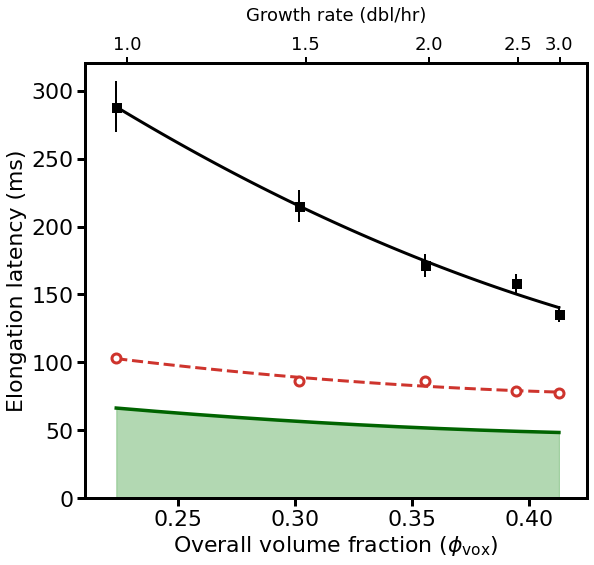

In [20]:
fig, ax = plt.subplots()

col = ['#2A2C77', '#CE342D']
gr_i_list = [1.0,1.5,2.0,2.5,3.0]
phi_list = np.array([0.22350473, 0.30181037, 0.35583449, 0.3945994, 0.413017898])
markers = ['*','^']

# TIME FOR SUCCESSFUL INCORPORATION AFTER TESTING COGNATE
SCALE = (1000/1475+1000/1529+1000/209+1000/200+1000/32)

# Plot experimental measurements of elongation latency from literature
y_model,SS_err,_,_,_ = np.polyfit(phi_list,[1000/15,1000/18,1000/19,1000/20,1000/21],2,full=True)
y_hat = np.polyval(y_model,phi_list)
x_sweep_i = np.linspace(min(phi_list),max(phi_list),1000)
y_hat_sweep_i = np.polyval(y_model, x_sweep_i)
ax.plot(x_sweep_i,y_hat_sweep_i,marker='o',markersize=0,markeredgewidth=3,markevery=199,linewidth=3.5,color='darkgreen')
ax.fill_between(x_sweep_i, y_hat_sweep_i, 0*y_hat_sweep_i, color='green',alpha=0.3)

# Plot data from original simulations, Maheshwari et al. (2022) mBio
sim_orig = [288.255328989, 215.020718814, 171.441002238, 158.078001416, 135.574725479]
sim_orig_errors = [19.0269983017527, 11.64055739798172, 8.261730763373709, 7.1361097692746406, 5.8932094579934868]
ax.errorbar(phi_list,sim_orig,sim_orig_errors,marker='s',markersize=7,markeredgewidth=3,zorder=1,linewidth=0,elinewidth=2,color='black')
p = np.polyfit(phi_list,sim_orig,2)
testphi=np.linspace(0.22350473,0.413017898)
ax.plot(testphi,np.polyval(p, testphi),color='k',linestyle='solid',linewidth=3)

# Plot data from new simulations, this work
vals = [rxndiff[d][2][0]+SCALE for d in sorted(rxndiff)]
errors = [rxndiff[d][5][0] for d in sorted(rxndiff)]
ax.errorbar(phi_list,vals,errors,elinewidth=0,color='#CE342D', linewidth=0, linestyle='dashed', markersize=9, marker='o',markerfacecolor='w', markeredgecolor='#CE342D', markeredgewidth=3)
p = np.polyfit(phi_list,vals,2)
testphi=np.linspace(0.22350473,0.413017898)
ax.plot(testphi,np.polyval(p, testphi),color='#CE342D',linestyle='dashed',linewidth=3)

ax.set_xlabel('Overall volume fraction $(\phi_{\mathrm{vox}})$',size=22,color='black')
ax.set_ylabel('Elongation latency (ms)',fontsize=22)
t = ax.yaxis.get_offset_text()
t.set_size(15)
t = ax.xaxis.get_offset_text()
t.set_size(15)
for ax in fig.get_axes():
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlim(0.21,0.425)
    ax.set_ylim(0,320)
    ax.tick_params(axis='both', labelsize=22,width=3,length=8)
    ax.tick_params(axis='both', which='minor', labelsize=16,width=2.5,length=6)
    
    ax1 = ax.twiny()
    ax1.set_xlim(0.205,0.425)
    ax1.tick_params(labelsize=18,width=2,length=6)
    ax1.set_xticks(phi_list)
    ax1.set_xlabel('Growth rate (dbl/hr)',size=18,color='black',labelpad=15)
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    labels = ['1.0','1.5','2.0','2.5','3.0']
    ax1.set_xticklabels(labels)

fig.set_size_inches(9,8)
plt.savefig('./images/Fig6.png', bbox_inches='tight', dpi=300)


$\textbf{FIGURE S11}$: Plotting transport and reaction components of total elongation latency, as a function of growth rate (x-axis) for both the original and new limited-valency simulations.

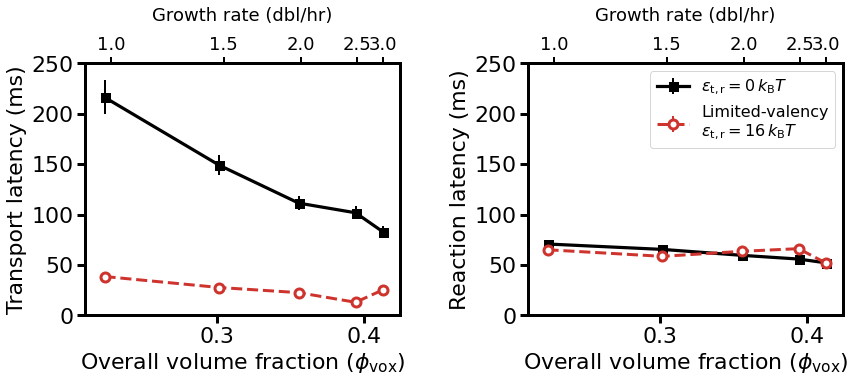

In [23]:
fig, (axt, axr) = plt.subplots(1,2)

# Plot data from original simulations, Maheshwari et al. (2022) mBio
prevsim_rxn = [70.73537145514294, 65.36998441796574, 59.502187713741364, 55.805417895138035, 52.08764068628781]
prevsim_rxn_error = [2.3896904099865064, 1.7394942942704879, 1.2512839939428426, 0.892753942092544, 0.7938581637983319]
prevsim_transp = [216.29638404953016, 148.7915624889631, 111.29650086910964, 101.69677914955025, 83.02328180376576]
prevsim_transperror = [16.78354800954726, 10.03590710312862, 7.091571679799831, 6.303865405961744, 5.155009095424843]
axt.errorbar(phi_list,prevsim_transp,prevsim_transperror,marker='s',markersize=7,markeredgewidth=3,zorder=1,linewidth=3.2,elinewidth=2,color='black')
axr.errorbar(phi_list,prevsim_rxn,prevsim_rxn_error,marker='s',markersize=7,markeredgewidth=3,zorder=1,linewidth=3.2,elinewidth=2,color='black', label=r'$\varepsilon_\mathrm{t,r}=0 \, k_\mathrm{B}T$')

# Plot data from new simulations, this work
vals = [rxndiff[d][0][0] for d in sorted(rxndiff)]
errors = [rxndiff[d][3][0] for d in sorted(rxndiff)]
axt.errorbar(phi_list,vals,errors,elinewidth=2,color='#CE342D', linestyle='dashed', linewidth=3, markersize=9, marker='o',markerfacecolor='w', markeredgecolor='#CE342D', markeredgewidth=3)
vals = [rxndiff[d][1][0]+SCALE for d in sorted(rxndiff)]
errors = [rxndiff[d][4][0] for d in sorted(rxndiff)]
axr.errorbar(phi_list,vals,errors,elinewidth=2,color='#CE342D', linestyle='dashed', linewidth=3, markersize=9, marker='o',markerfacecolor='w', markeredgecolor='#CE342D', markeredgewidth=3, label='Limited-valency\n' + r'$\varepsilon_\mathrm{t,r}=16 \, k_\mathrm{B}T$')

##

axr.set_xlabel('Overall volume fraction $(\phi_{\mathrm{vox}})$',size=22,color='black')
axr.set_ylabel('Reaction latency (ms)',fontsize=22)
axr.legend(prop={'size': 16},loc='upper right')
axt.set_xlabel('Overall volume fraction $(\phi_{\mathrm{vox}})$',size=22,color='black')
axt.set_ylabel('Transport latency (ms)',fontsize=22)
for ax in fig.get_axes():
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlim(0.21,0.425)
    ax.set_ylim(0,250)
    ax.tick_params(axis='both', labelsize=22,width=3,length=8)
    ax.tick_params(axis='both', which='minor', labelsize=16,width=2.5,length=6)
    
    ax1 = ax.twiny()
    ax1.set_xlim(0.205,0.425)
    ax1.tick_params(labelsize=18,width=2,length=6)
    ax1.set_xticks(phi_list)
    ax1.set_xlabel('Growth rate (dbl/hr)',size=18,color='black',labelpad=15)
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    labels = ['1.0','1.5','2.0','2.5','3.0']
    ax1.set_xticklabels(labels)

fig.set_size_inches(13,6.5)
fig.tight_layout(pad=5)
plt.savefig('./images/FigS14.png', bbox_inches='tight', dpi=300)


$\textbf{FIGURE S13}$: Plotting probability distributions for latencies of intra-ribosomal kinetics, depending on if the TC is a cognate or non-cognate. Same data as in Figure S2 of Maheshwari et al. (2022) mBio.

In [28]:
# Intra-ribosomal kinetics from in vitro experiments, see Table S5 of Maheshwari et al. (2022) mBio
k1r=718
k2f=1475
k2r_cog=2.1
k3_cog=1529
k4=209
k5_cog=200
k6_cog = 32
t1r = 1000/k1r
t2f = 1000/k2f
t2r_cog = 1000/k2r_cog
t3_cog = 1000/k3_cog
t4 = 1000/k4
t5_cog = 1000/k5_cog
t6_cog = 1000/k6_cog

np.random.seed(1)
t1r_exp=np.random.exponential(t1r,size=4000)
t2f_exp=np.random.exponential(t2f,size=4000)
t2r_cog_exp=np.random.exponential(t2r_cog,size=4000)
t3_cog_exp=np.random.exponential(t3_cog,size=4000)
t4_exp=np.random.exponential(t4,size=4000)
t5_cog_exp=np.random.exponential(t5_cog,size=4000)
t6_cog_exp = np.random.exponential(t6_cog,size=4000)


In [29]:
# Calculating latencies for intra-ribosomal kinetics, Markov process & transition rates (see SI Methods, Maheshwari et al.)

### Cognate calculation
dwelltime_cog_success = list()
dwelltime_cog_fail = list()
count = 0
count1 = 0
reject_after_recognition_count = 0
N = 1000000
tscale = 1/(0.0000005*4*0.0067723)

#Set include t2r true to compute the probability of rejection following codon recognition
includet2r = True

for i in range(N):
    dwell_t = 0
    state=1
    codon_recognition = False

    while state != 0 and state != 3:
        dwell_t1r = np.random.choice(t1r_exp)
        dwell_t2f = np.random.choice(t2f_exp)
        if state==1:
            if dwell_t1r<dwell_t2f:
                dwell_t+=np.random.choice(t1r_exp)
                dwelltime_cog_fail.append(dwell_t)
                state=0
                if codon_recognition:
                    reject_after_recognition_count +=1
                continue;
            else:
                dwell_t+=np.random.choice(t2f_exp)
                state = 2
                codon_recognition = True
                
        if state==2:
            count+=1
            dwell_t2r_cog = np.random.choice(t2r_cog_exp)
            dwell_t3_cog = np.random.choice(t3_cog_exp)
            if dwell_t2r_cog<dwell_t3_cog:
                if includet2r:
                    dwell_t+= np.random.choice(t2r_cog_exp)
                    state = 1
                else:
                    state = 2
            else:
                count1+=1
                dwell_t += np.random.choice(t3_cog_exp)
                state = 3
        
        if state==3:
            dwell_t+=np.random.choice(t4_exp)+np.random.choice(t5_cog_exp)+np.random.choice(t6_cog_exp)
            
    if state!=0: dwelltime_cog_success.append(dwell_t)
        
dwelltime_cog_success = [int(i*tscale) for i in dwelltime_cog_success]
dwelltime_cog_fail = [int(i*tscale) for i in dwelltime_cog_fail]

np.save('../Data/FIG6_S13_S14__ElongationLatencies/dwelltime_cog_success.npy',dwelltime_cog_success)
np.save('../Data/FIG6_S13_S14__ElongationLatencies/dwelltime_cog_fail.npy',dwelltime_cog_fail)


### Non-cognate calculation (distribution pulling from exponential)
dwelltime_non=(np.random.exponential(t1r,size=N))
dwelltime_non = [int(i*tscale) for i in dwelltime_non]

np.save('../Data/FIG6_S13_S14__ElongationLatencies/dwelltime_non.npy',dwelltime_non)


Average dwell time (cog_success): 43.1  ms
Average dwell time (cog_fail): 1.9  ms
Average dwell time (non): 1.4  ms


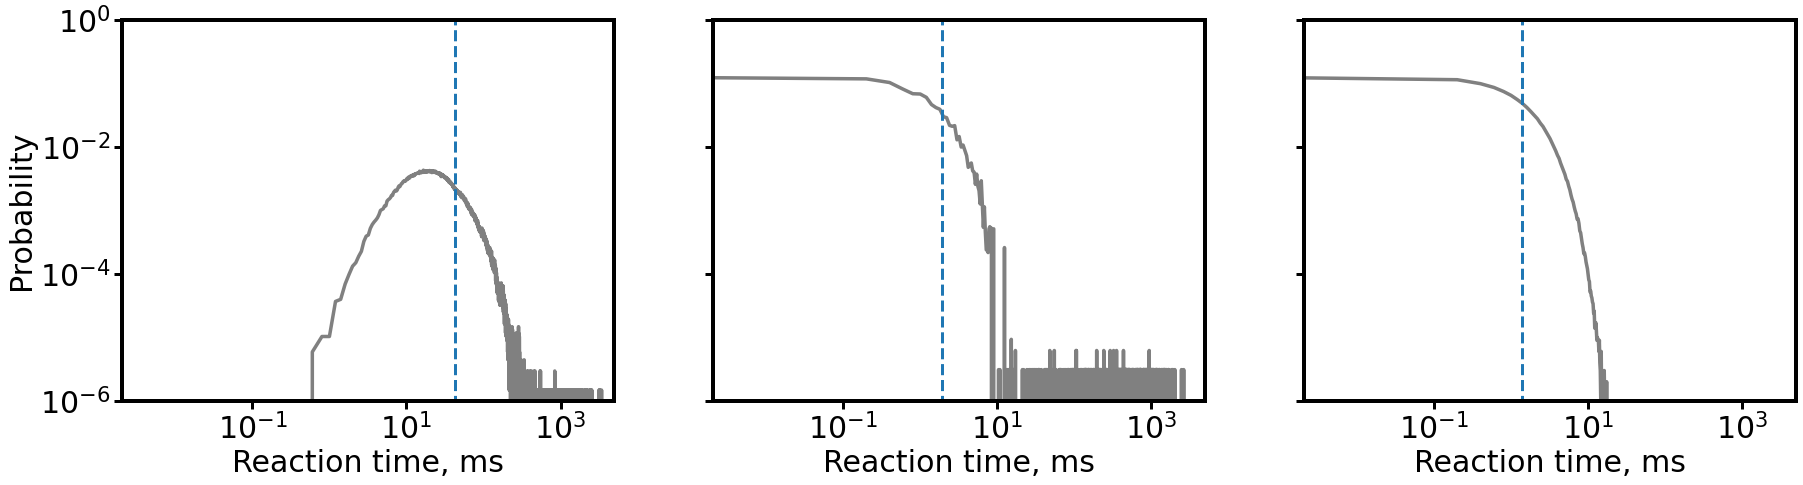

In [30]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3)
tscale = 1/(0.0000005*4*0.0067723)
axes_all = [ax1,ax2,ax3]

names = ['cog_success', 'cog_fail', 'non']
binspacing = np.linspace(1e-5, 1e4, num=50000)

for j in range(0,3):
    dwelltime = np.load('../Data/FIG6_S13_S14__ElongationLatencies/dwelltime_{}.npy'.format(names[j]))
    dwelltime = [i/tscale for i in dwelltime] # conversion into ms
    axes_curr = axes_all[j]
    hist, bins = np.histogram(dwelltime, binspacing)
    tot = np.sum(hist)
    hist = hist / tot
    axes_curr.plot(bins[:-1], hist, color='grey',linewidth=3.5)
    axes_curr.plot([np.average(dwelltime)]*2,[0,10],linewidth=3,linestyle='dashed')
    print("Average dwell time ({}):".format(names[j]), round(np.average(dwelltime),1), " ms")

t = ax1.yaxis.get_offset_text()
t.set_size(15)
t = ax1.xaxis.get_offset_text()
t.set_size(15)
for ax in fig.get_axes():
    ax.set_xlim(1e-5,8e3)
    ax.set_xlim(1.5/tscale*100000,5e3)
    ax.set_yscale('log')
    ax.set_ylim(1e-6,1)
    ax.set_xscale('log')
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(4)
    ax.spines['right'].set_linewidth(4)
    ax.set_xlabel('Reaction time, ms',size=30)
    ax.set_ylabel('Probability',size=30)
    ax.tick_params(axis='both', labelsize=30,width=3,length=8)
    ax.tick_params(axis='both', which='minor', labelsize=16,width=2.5,length=6)

for ax in fig.get_axes():
    ax.label_outer()
        
fig.set_size_inches(30,7)
plt.savefig('./images/FigS13.png', bbox_inches='tight', dpi=300)
